In [613]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### VISUALIZE AND QUANTIZE 

In [614]:
"""
Cell Purpose: Load all the gesture training data and append it to two variables

Variable: 
- time_data: "Specific times that acceleration was observed"
- acceleration_data: "Specific linear and angular acceleration at specific times"

Variable Shapes: 
- time_data = (4111, 1) = (# instances, 1 Time)
- acceleration_data = (4111, 6) = (# Instances, 6 acceleration columns)
"""

def load_file(file_name):
    return np.loadtxt(file_name)

fname = "Data/ECE5242Proj2_train_additional-selected/wave31.txt"
gesture_data = load_file(fname)
time_data = gesture_data[:, 0][:, np.newaxis]
acceleration_data = gesture_data[:, 1:]

# # Append all of the gesture data which we will discretize the data 
# for i in range(len(os.listdir("Data/ECE5242Proj2_train_additional-selected/"))):
#     fname = os.listdir("Data/ECE5242Proj2_train_additional-selected/")[i]
#     path = os.path.join("Data/ECE5242Proj2_train_additional-selected/", fname)
#     gesture_data = load_file(path)

#     if i == 0:
#         time_data = gesture_data[:, 0][:, np.newaxis]
#         acceleration_data = gesture_data[:, 1:]
#     else:
#         time_data = np.row_stack((time_data, gesture_data[:, 0][:, np.newaxis])) # NOT SURE IF THIS IS CORRECT
#         acceleration_data = np.row_stack((acceleration_data, gesture_data[:, 1:]))

print(acceleration_data.shape, time_data.shape)

(441, 6) (441, 1)


/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


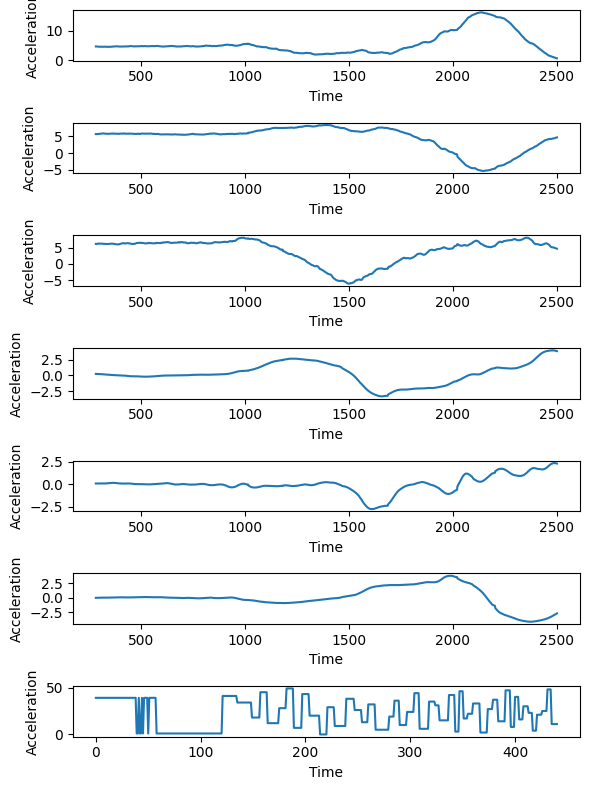

In [615]:
"""
Cell Purpose: Use KMeans to discretize the raw sensor data which is seen in the last graph. 

Variables:
- num_of_clusters = "using kmeans to create clusters which brings down the number of dimensions from 6 to 1"
- M = "discrete observations or KMeans clusters"
- O = "Observations"

Variable Shapes:
- num_of_clusters = float

"""
def plot_continuous_discrete(clusters, time, acceleration):
    # Plot the data
    fig, axs = plt.subplots(nrows=7, ncols=1, sharex=False, sharey=False, figsize=(6, 8))

    # Plot each channel in a separate subplot
    for i, ax in enumerate(axs):
        if i < 6:
            ax.plot(time, acceleration[:, i])
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')
        else:
            ax.plot(clusters)
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')

    # # Adjust the layout and spacing of the subplots
    fig.tight_layout()

    # Show the plot
    plt.show()


M = 50
O = KMeans(n_clusters=M).fit_predict(acceleration_data)
plot_continuous_discrete(O, time_data, acceleration_data)

## IMPLEMENT HMM

In [639]:
"""
Cell Purpose: Initialize the model parameters

Variables:
- N: Number of states
- M: Number of observation classes or clusters
- A: Transition Matrix
- pi: Initial probability we are in a a specific state

Variable Shapes
- N: float
- A: (Number of states, number of states)
- pi: (N, 1)
"""

def init_a_matrix(N):
    A = np.zeros((N, N))
    for i in range(N):
        A[i, i] = 0.5
        if i + 1 < N:
            A[i + 1, i] = 0.5
    
    A[0, -1] = 0.5 # This is to make sure it can transition to another state
    return A

def init_pi_matrix(N):
    pi = np.zeros((N))
    pi[0] = 1
    return pi

def init_b_matrix(N, M):
    arr = np.random.rand(N, M)
    arr = arr / np.sum(arr, axis=1, keepdims=True)
    return arr

N = 10
A = init_a_matrix(N)
B = init_b_matrix(N, M)
pi = init_pi_matrix(N)

print("\nA: ", A)
print("\nB: ", B)
print("\nPi: ", pi)
# print("\nO: ", O)


A:  [[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]]

B:  [[0.02290103 0.00507648 0.0052477  0.03173098 0.03600664 0.02658956
  0.01574593 0.01858657 0.03069282 0.02537906 0.01261253 0.02657708
  0.02683144 0.00839537 0.03010416 0.03120093 0.0341047  0.02326159
  0.00724196 0.01009456 0.00060147 0.02720835 0.03354336 0.03074183
  0.02546651 0.013789   0.01816407 0.01126125 0.00816703 0.003093
  0.01532433 0.02545112 0.02494525 0.01539158 0.01645934 0.00254422
  0.0292301  0.0099191  0.01574193 0.0126167  0.03484052 0.00282879
  0.03450089 0.02117273 0.01869571 0.02357017 0.01585196 0.03711535
  0.03248385 0.01

In [648]:
"""
Variables:
- O: "Each observation is assigned a cluster number which also indicates"
- B: "Observation/Emission Matrix"
- pi: "Initial state probabilities"
- Alpha: "Probability you are in state j given a sequence of observations up to t-1"
- Beta: "Probability of seeing a sequence of future observations"
- A: "Transition Matrix"
- Gamma: "Probability of being in state i at time T"
- Chi: "Probability of going from state i to state j given observation sequence"
- c: "Scaling factor to prevent underflow"


Variable Shapes:
- O: (4111,) = (Gesture Instances, 1)
- B: (10 , 50) = (Number of hidden states, Number of clusters)
- pi: (10, 1) = (Number of hidden states, 1)
- Alpha: ( Length of the observation sequence, Number of hidden states)
- Beta: (Length of observation sequence, Number of hidden states)
- A: (Number of hidden states, number of hidden states))
- Gamma: (Number of hidden states, Length of observation sequence)
- Chi: (Number of hidden states, Number of hidden states, Length of observation sequence)
- c: (Length of observation sequence)
"""

class HMM():
    def __init__(self, N, M, A, B, pi, O):
        self.N = N
        self.M = M
        self.A = A
        self.B = B
        self.pi = pi
        self.O = O
        self.T = self.O.shape[0] # Length of the sequence

    def calculate_alpha(self):
        alpha = np.zeros((self.T, self.N))
        c = np.ones((self.T))

        # Calculate base case
        alpha[0, :] = self.pi * self.B[:, self.O[0]]
        c[0] = 1 / (np.sum(alpha[0, :]) + 1e-6) # Scaling factor take -log at the end to revert
        alpha[0, :] = c[0] * alpha[0, :]
        
        # Inductive step
        for t in range(1, self.T):
            # for i in range(self.N):
                # alpha[t, i] = np.sum(alpha[t-1, :] * self.A[i, :]) * self.B[i, self.O[t]] # Do dot here
            alpha[t, :] = np.dot(alpha[t-1, :], self.A) * self.B[:, self.O[t]] # Testing
            c[t] = 1 / (np.sum(alpha[t, :]) + 1e-6)
            alpha[t, :] = c[t] * alpha[t, :]

        return alpha, c
    
    def calculate_beta(self, c):
        beta = np.zeros((self.T, self.N))

        # Calculate base case
        beta[self.T - 1, :] = c[self.T-1] * 1

        # inductive step
        for t in range((self.T - 2), -1, -1):
            # for i in range(self.N):
                # beta[t, i] = np.sum(self.A[:, i] * self.B[:, self.O[t + 1]] * beta[t+1, :]) # Do dot here
            beta[t, :] = np.dot(self.A, (self.B[:, self.O[t+1]] * beta[t+1, :])) # Testing
            beta[t, :] = c[t] * beta[t, :]

        return beta
    
    def calculate_gamma(self, alpha, beta):
        gamma = np.zeros((self.T, self.N))
        
        # for i in range(self.N):
            # for t in range(self.T):
                # gamma[t, i] = (alpha[t, i] * beta[t, i]) / np.sum(alpha[t, :] * beta[t, :]) # Do dot here
        gamma = (alpha * beta) / (np.sum(alpha * beta, axis=1)[:, np.newaxis] + 1e-6) # Check axis just in case

        return gamma
    
    def calculate_chi(self, alpha, beta): # NOT SURE ABOUT THIS
        chi = np.zeros((self.T, self.N, self.N))
        
        for t in range(self.T - 1):
            for i in range(self.N):
                for j in range(self.N):
                    numerator = alpha[t, i] * self.A[j, i] * self.B[j, O[t + 1]] * beta[t+1, j]
                    denominator = np.sum(alpha[t, :] * self.A[:, j] * self.B[j, self.O[t + 1]] * beta[t+1, :]) + 1e-6 # NOT SURE ABOUT THIS
                    chi[t, i, j] = numerator / denominator
        
        return chi
    
    def adjust_a(self, chi, gamma):
        temp_A = np.zeros((self.N, self.N))

        for i in range(self.N):
            for j in range(self.N):
                temp_A[j, i] = np.sum(chi[:self.T-1, i, j], axis=0) / (np.sum(gamma[:self.T-1, i], axis=0) + 1e-6) # Double check denom
        
        return temp_A
    
    def adjust_b(self, gamma):
        temp_B = np.zeros((self.N, self.M))
                        
        for i in range(self.N):
            for o in range(self.M):
                temp_B[i, o] = np.sum(gamma[self.O==o, i], axis=0) / (np.sum(gamma[:, i], axis=0) + 1e-6) # Not sure if this is right

        return temp_B

    def Baum_Welsh(self):
        # Forward
        alpha, c = self.calculate_alpha()

        # Backward
        beta = self.calculate_beta(c)

        # E Step
        gamma = self.calculate_gamma(alpha, beta)
        chi = self.calculate_chi(alpha, beta)

        # M Step
        pi = gamma[0, :]
        A = self.adjust_a(chi, gamma) # SOMEWHERE HERE IS GETTING MESSED UP
        B = self.adjust_b(gamma)

        # Calculate likelihood
        likelihood = -np.sum(np.log(c))


        return A, B, pi, likelihood

In [649]:
def train_model(epochs, N, M, A, B, pi, O):
    model = HMM(N, M, A, B, pi, O)
    for epoch in range(epochs):
        # print("Before A: ", A)
        # print("B: ", B)
        # print("pi: ", pi)
        A, B, pi, likelihood = model.Baum_Welsh()
        # print("After A: ", A)
        # print("B: ", B)
        # print("pi: ", pi)
        model.A = A
        model.B = B
        model.pi = pi
        print("\nEpoch: ", epoch)
        print("\nLikelihood: ", likelihood)

train_model(100, N, M, A, B, pi, O)


Epoch:  0

Likelihood:  -1697.9310426493978

Epoch:  1

Likelihood:  283.5057885171955

Epoch:  2

Likelihood:  2222.0843638640754

Epoch:  3

Likelihood:  6987.085781700665

Epoch:  4

Likelihood:  16302.995295374745

Epoch:  5

Likelihood:  31435.759057479056


/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/3129247029.py:65: RuntimeWarning: invalid value encountered in multiply
  beta[t, :] = np.dot(self.A, (self.B[:, self.O[t+1]] * beta[t+1, :])) # Testing
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/3129247029.py:76: RuntimeWarning: invalid value encountered in multiply
  gamma = (alpha * beta) / (np.sum(alpha * beta, axis=1)[:, np.newaxis] + 1e-6) # Check axis just in case
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/3129247029.py:87: RuntimeWarning: invalid value encountered in multiply
  denominator = np.sum(alpha[t, :] * self.A[:, j] * self.B[j, self.O[t + 1]] * beta[t+1, :]) + 1e-6 # NOT SURE ABOUT THIS
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_87329/3129247029.py:86: RuntimeWarning: invalid value encountered in double_scalars
  numerator = alpha[t, i] * self.A[j, i] * self.B[j, O[t + 1]] * beta[t+1, j]



Epoch:  6

Likelihood:  57767.381564641044

Epoch:  7

Likelihood:  nan

Epoch:  8

Likelihood:  nan

Epoch:  9

Likelihood:  nan

Epoch:  10

Likelihood:  nan

Epoch:  11

Likelihood:  nan

Epoch:  12

Likelihood:  nan

Epoch:  13

Likelihood:  nan

Epoch:  14

Likelihood:  nan

Epoch:  15

Likelihood:  nan

Epoch:  16

Likelihood:  nan

Epoch:  17

Likelihood:  nan


KeyboardInterrupt: 